<a href="https://colab.research.google.com/github/marti1310/TweetClassification/blob/main/AnalyseDesDonnees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Conclusion de l'analyse des données :


In [ ]:
!pip install xgboost
!pip install emoji
!pip install optuna
!pip install nltk
!pip install imblearn

In [ ]:
# Importation des différentes librairies utiles pour le notebook

# Sickit learn met régulièrement à jour des versions et
# indique des futurs warnings.
# Ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Bibliothèques générales
import pickle  # Sauvegarde et chargement des modèles
import joblib # Sauvegarde et chargement des modèles
from joblib import dump
from joblib import load
import pandas as pd  # Manipulation des dataframes
import numpy as np  # Calculs numériques et manipulation de tableaux
import time  # Mesure du temps d'exécution
import sys  # Gestion du système
import random # Génération de nombres aléatoires
from IPython.display import Image, display # Pour afficher une image et l'avoir en Latex

# Bibliothèques pour l'affichage
import matplotlib.pyplot as plt  # Visualisation de graphiques
import seaborn as sns  # Visualisation avancée avec des graphiques stylisés
import plotly.express as px # Visualisation simplifiée et rapide avec Plotly
import plotly.io as pio

# Bibliothèques scikit-learn
from sklearn import datasets  # Chargement des datasets intégrés de scikit-learn (comme IRIS)
from sklearn.utils import shuffle # Pour mélanger les données
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Séparation des données en train/test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import optuna
import logging

logging.getLogger("optuna").setLevel(logging.WARNING)

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

import string
import unicodedata
import emoji
import re
import asyncio

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import sys
my_local_drive='/content/gdrive/MyDrive/Colab Notebooks/ML1/Projet'
sys.path.append(my_local_drive)

In [ ]:
import os

os.chdir(my_local_drive)

In [ ]:
%ls

AnalyseDesDonnees.ipynb  scitweets_export.gsheet   tweets-augmentation4.tsv
final.tsv                scitweets_export.tsv
ProjetML.ipynb           tweets-augmentation3.tsv


In [ ]:
#attention le séparateur est une tabulation
df=pd.read_csv('final.tsv', sep='\t')
display (df.head())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,3.166700e+17,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,0,3.166700e+17,"My knees are a little sore, which I take as a ...",0,0.0,0.0,0.0
2,0,3.166700e+17,"I can feel some soreness in my knees, so it se...",0,0.0,0.0,0.0
3,1,3.190909e+17,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
4,1,3.190909e+17,Grabbing McDonald's breakfast before hitting t...,0,0.0,0.0,0.0


In [ ]:
def word_cloud(text):
  tweet = text.str.cat(sep=' ')
  words=tweet.split()
  word_counts=Counter(words)
  total = len(tweet)
  filtered_counts = {word: (count/total)*100 for word, count in word_counts.items() if count >= 20}

  fig = px.treemap(
      names=list(filtered_counts.keys()),
      parents=[""] * len(filtered_counts),
      values=list(filtered_counts.values()),
      title="Word Cloud interactif sous la forme d'un treemap (mots avec fréquence >= 20)"
   )
  fig.update_traces(
      marker=dict(
        colors=list(filtered_counts.values()),
        colorscale=[(0, 'lightblue'), (0.5, 'orange'), (1, 'darkred')],
        colorbar=dict(title="Fréquence en por")
        )
      )
  fig.show()


In [ ]:
#Word_cloud du dataset initial
word_cloud(df['text'])

les mots les plus fréquents des données d'origine sont des déterminants ("the", "a"), des prépositions ("of","to","in") et la conjontion ("and"). À supprimer lors de prétraitrements avec stopWords.

### Prétraitrements

In [ ]:
TWITTER_ABBREVIATIONS = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "y": "why",
    "pls": "please",
    "plz": "please",
    "thx": "thanks",
    "k": "okay",
    "lol": "laughing out loud",
    "idk": "i do not know",
    "imo": "in my opinion",
    "lmao": "laughing my ass off",
    "brb": "be right back",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "smh": "shaking my head",
    "fyi": "for your information",
    "ppl": "people",
    "some1": "someone",
    "b4": "before",
    "gr8": "great",
    "bff": "best friends forever",
    "wtf": "what the fuck",
    "tbh": "to be honest",
    "bc": "because",
    "nvm": "never mind",
    "u2": "you too",
    "cuz": "because",
    "wanna": "want to",
    "gonna": "going to",
    "ab": "about", "abt": "about", "b/c": "because", "b": "be", "b4": "before", "bc":"because", "@": "at",
    "bfn": "bye for now", "bgd": "background", "br": "best regards", "btw": "by the way",
    "chk": "check", "cld": "could", "clk": "click", "cre8": "create", "da": "the",
    "deets": "details", "dm": "direct message", "em": "email", "eml": "email",
    "ema": "email address", "f2f": "face to face", "fab": "fabulous", "ff": "followfriday",
    "ftl": "for the loss", "ftw": "for the win", "hand": "have a nice day", "ht": "hat tip",
    "ic": "i see", "icymi": "in case you missed it", "idk": "i don't know", "imo": "in my opinion",
    "kk": "okay", "mtf": "more to follow", "nts": "note to self", "oh": "overheard",
    "prt": "please retweet", "rt": "retweet", "smh": "shaking my head", "sns": "social networking site",
    "sp": "sponsored", "tbh": "to be honest", "tbt": "throwback thursday", "tftf": "thanks for the follow",
    "tmb": "tweet me back", "u": "you", "woz": "was", "wtv": "whatever", "ykyat": "you know you're addicted to",
    "yolo": "you only live once", "yoyo": "you're on your own"
}

In [ ]:
def expand_abbreviations(text, abbreviations_dict=TWITTER_ABBREVIATIONS):
    words = text.split()
    expanded_words = []
    for word in words:
        # Nettoyage ponctuel pour uniformiser
        word_clean = re.sub(r'\W+', '', word.lower())  # supprime la ponctuation pour matcher
        if word_clean in abbreviations_dict:
            expanded = abbreviations_dict[word_clean]
            expanded_words.append(expanded)
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)


In [ ]:
def normalize_text(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {'not', 'no'}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # supprime la ponctuation et les chiffres
    tokens = [t for t in tokens if not t.startswith('http')] #supprime url
    tokens = [t for t in tokens if t not in stop_words] #stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens] #lemmatisateur
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def stem_words(text):
    word_tokens = text.split()
    stems = [stemmer.stem(word) for word in word_tokens]
    return " ".join(stems)


In [ ]:
stemmer = PorterStemmer()

In [ ]:
df['text']=df['text'].apply(expand_abbreviations)
df['text']=df['text'].apply(normalize_text)
df['text']=df['text'].apply(clean_text)
df['text']=df['text'].apply(stem_words)

In [ ]:
science_related = df['text'][df['science_related'] == 1]
non_science_related = df['text'][df['science_related'] == 0]
scientific_claim = df['text'][df['scientific_claim'] == 1]
non_scientific_claim = df['text'][df['scientific_claim'] == 0]
scientific_reference = df['text'][df['scientific_reference'] == 1]
non_scientific_reference = df['text'][df['scientific_reference'] == 0]

In [ ]:
#Affichage word cloud des données après prétraitrements pour non-science related
print(word_cloud(non_science_related))

None


In [ ]:
#Affichage word cloud des données après prétraitrements pour science related
print(word_cloud(science_related))

None


Les mots les plus communs dans les tweets science related et non science related sont

In [ ]:
print(word_cloud(scientific_claim))

None


In [ ]:
print(word_cloud(non_scientific_claim))

None


In [ ]:
print(word_cloud(scientific_reference))

None


In [ ]:
print(word_cloud(non_scientific_reference))

None


#Score de corrélation entre classes

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stopwords(text, lang):
    stop_words = set(stopwords.words(lang))  # ou 'english'

    words = word_tokenize(text)
    return ' '.join([w for w in words if w.lower() not in stop_words])

def remove_punctuation(text):
    # remplace les guillemets et apostrophes typographiques par leurs équivalents ASCII
    text = text.replace("“", '"').replace("”", '"').replace("’", "'")

    # supprime toute ponctuation ASCII standard
    return text.translate(str.maketrans('', '', string.punctuation))

def replace(text, rep):
  if (rep == 0):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\b(19|20)\d{2}\b", "year", text)
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)
  else:
    text = re.sub(r"http\S+|www\S+", "url", text)
    text = re.sub(r"\b(19|20)\d{2}\b", "year", text)
    text = re.sub(r'\b\d+(\.\d+)?\b', 'num', text)
  return text

def preprocess(text):
  text = text.lower()
  text = re.sub(r"@\w+", '', text)  # mentions
  text = re.sub(r"#", "", text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = emoji.demojize(text)

  return text

def lem_words(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

def full_clean(text):
    text = replace(text, 0)
    text = preprocess(text)
    text = remove_punctuation(text)
    text = lem_words(text)
    return text



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
!ls

AnalyseDesDonnees.ipynb  scitweets_export.gsheet   tweets-augmentation4.tsv
final.tsv		 scitweets_export.tsv
ProjetML.ipynb		 tweets-augmentation3.tsv


In [ ]:
df_base = pd.read_csv('scitweets_export.tsv', sep='\t')
df_final = pd.read_csv('final.tsv', sep='\t')

In [ ]:
print(df_final.columns)


Index(['Unnamed: 0', 'tweet_id', 'text', 'science_related', 'scientific_claim',
       'scientific_reference', 'scientific_context'],
      dtype='object')


In [ ]:
df_final['text'] = df_final['text'].apply(expand_abbreviations)
df_base['text'] = df_base['text'].apply(expand_abbreviations)

df_final['text'] = df_final['text'].apply(full_clean)
df_base['text'] = df_base['text'].apply(full_clean)

In [ ]:
corr_claim_reference = df_final['scientific_claim'].corr(df_final['scientific_reference'])
corr_claim_related = df_final['scientific_claim'].corr(df_final['science_related'])
corr_reference_related = df_final['scientific_reference'].corr(df_final['science_related'])

In [ ]:
corr_claim_reference_base = df_base['scientific_claim'].corr(df_base['scientific_reference'])
corr_claim_related_base = df_base['scientific_claim'].corr(df_base['science_related'])
corr_reference_related_base = df_base['scientific_reference'].corr(df_base['science_related'])

In [ ]:
print("Correlation dans le dataset augmenté:\n")
print(corr_claim_reference)
print(corr_claim_related)
print(corr_reference_related)
print("\nCorrelation dans le dataset original:\n")
print(corr_claim_reference_base)
print(corr_claim_related_base)
print(corr_reference_related_base)

Correlation dans le dataset augmenté:

0.17926109110475655
0.6131115568601044
0.5452734281842554

Correlation dans le dataset original:

0.4199949257936822
0.7821556039724705
0.6648035153192209


# Distribution des classes

In [ ]:
print(df_final['science_related'].value_counts())

science_related
0    2393
1    2170
Name: count, dtype: int64


In [ ]:
print(df_base['science_related'].value_counts())

science_related
0    765
1    375
Name: count, dtype: int64


In [ ]:
CLAIMREF = df_final['scientific_reference']+df_final['scientific_claim']
print(CLAIMREF.value_counts())

0.0    2826
1.0    1345
2.0     392
Name: count, dtype: int64


In [ ]:
CLAIMREF = df_base['scientific_reference']+df_base['scientific_claim']
print(CLAIMREF.value_counts())

0.0    798
1.0    218
2.0    124
Name: count, dtype: int64


In [ ]:
print(df_base['scientific_context'].value_counts())

scientific_context
0.0    889
1.0    251
Name: count, dtype: int64


In [ ]:
print(df_final['scientific_context'].value_counts())

scientific_context
0.0    3115
1.0    1448
Name: count, dtype: int64


In [ ]:
print(df_base['scientific_reference'].value_counts())

scientific_reference
0.0    937
1.0    203
Name: count, dtype: int64


In [ ]:
print(df_final['scientific_reference'].value_counts())

scientific_reference
0.0    3594
1.0     969
Name: count, dtype: int64


In [ ]:
print(df_base['scientific_claim'].value_counts())

scientific_claim
0.0    877
1.0    263
Name: count, dtype: int64


In [ ]:
print(df_final['scientific_claim'].value_counts())

scientific_claim
0.0    3403
1.0    1160
Name: count, dtype: int64


#Liste des mots les plus fréquents

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_final['text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_counts = word_freq.sum(axis=0).sort_values(ascending=False)
print(word_counts.head(10))
print('\n')
X2 = vectorizer.fit_transform(df_base['text'])
word_freq2 = pd.DataFrame(X2.toarray(), columns=vectorizer.get_feature_names_out())
word_counts2 = word_freq2.sum(axis=0).sort_values(ascending=False)

print(word_counts2.head(10))

stop        192
support     167
people       76
report       75
year         70
new          68
cause        61
increase     49
lead         44
science      42
dtype: int64


support     465
stop        446
year        305
new         304
study       251
people      247
report      243
science     197
cause       186
research    169
dtype: int64


In [ ]:
def get_word_counts(df, column_name):
    filtered_df = df[df[column_name] == 1]
    X = vectorizer.fit_transform(filtered_df['text'])
    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    word_counts = word_freq.sum(axis=0).sort_values(ascending=False)
    word_counts = word_counts.head(10)
    return word_counts


# Fonction améliorée pour afficher les résultats sous forme de barres groupées
def plot_comparison_word_counts(claim_counts, reference_counts, context_counts, title):
    # Trouver les 10 mots les plus fréquents (en commun) dans chaque série
    common_words = list(set(claim_counts.index).union(reference_counts.index).union(context_counts.index))
    common_words = common_words[:10]  # Limiter à 10 mots

    # Compléter les séries pour s'assurer que chaque colonne a les mêmes indices
    claim_counts = claim_counts.reindex(common_words, fill_value=0)
    reference_counts = reference_counts.reindex(common_words, fill_value=0)
    context_counts = context_counts.reindex(common_words, fill_value=0)

    # Créer un DataFrame pour comparer les trois catégories
    comparison_df = pd.DataFrame({
        'Mot': common_words,
        'Claim': claim_counts.values,
        'Reference': reference_counts.values,
        'Context': context_counts.values
    })

    # Créer le plot
    comparison_df.set_index('Mot').plot(kind='bar', figsize=(12, 6), color=['#FF6347', '#4682B4', '#32CD32'])

    # Ajouter des labels et un titre
    plt.title(title)
    plt.xlabel('Mots')
    plt.ylabel('Fréquence')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()





In [ ]:
claim_word_counts = get_word_counts(df_final, 'scientific_claim')
reference_word_counts = get_word_counts(df_final, 'scientific_reference')
context_word_counts = get_word_counts(df_final, 'scientific_context')
print('\n')
print(claim_word_counts)
print(reference_word_counts)
print(context_word_counts)
print('\n')
print('\n')
claim_word_counts2 = get_word_counts(df_base, 'scientific_claim')
reference_word_counts2 = get_word_counts(df_base, 'scientific_reference')
context_word_counts2 = get_word_counts(df_base, 'scientific_context')
print('\n')
print(claim_word_counts2)
print(reference_word_counts2)
print(context_word_counts2)



study       29
increase    26
people      22
health      20
cause       20
lead        18
new         17
help        17
year        17
cancer      15
dtype: int64
study        26
new          21
science      13
research     13
year         13
health       12
scientist    12
brain        12
eurekamag    11
people       11
dtype: int64
study        32
science      25
new          24
research     24
year         15
cancer       13
health       13
scientist    13
brain        13
support      12
dtype: int64






study       133
increase     94
health       88
year         87
new          76
people       74
cancer       70
help         69
cause        68
lead         67
dtype: int64
study        134
new          102
research      76
year          69
scientist     55
science       55
brain         51
people        51
health        50
eurekamag     48
dtype: int64
study        192
new          152
research     136
science      133
year          94
scientist     82
cancer        71
brain   

#DENSITE des MOTS

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

X = vectorizer.fit_transform(df_final['text'])
total_words = df_final['text'].str.split().apply(len)

non_stop_words = X.sum(axis=1)
density = non_stop_words / total_words
df['word_density'] = density


print(df[['text', 'word_density']].head())


#DISTRIBUTION des TYPES de MOTS pour CIBLER PRETRAITEMENT


In [ ]:
import spacy
import pandas as pd

# Charger le modèle français de spaCy
nlp = spacy.load('en_core_web_sm')

# Fonction pour obtenir la distribution des types de mots
def pos_distribution(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return pos_tags

# Appliquer la fonction sur la colonne 'text'
df_final['pos_tags'] = df_final['text'].apply(pos_distribution)

# Calculer la distribution des types de mots
all_pos_tags = [tag for sublist in df_final['pos_tags'] for tag in sublist]
pos_dist = pd.Series(all_pos_tags).value_counts()

print("Distribution des types de mots :")
print(pos_dist)


Distribution des types de mots :
NOUN     5794
VERB     2387
PROPN    1968
ADJ      1668
ADV       425
AUX       253
ADP       147
PRON      133
NUM       101
PART       98
INTJ       83
PUNCT      64
SCONJ      30
DET        29
X          23
CCONJ      11
SYM         2
Name: count, dtype: int64


#ANALYSE BIGRAMME

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_final['text'])

bigram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bigram_counts = bigram_freq.sum(axis=0).sort_values(ascending=False)


print(bigram_counts.head(10))


new study         7
dont stop         7
new york          6
got ta            6
climate change    6
laughing loud     6
police officer    5
oral history      5
social medium     5
people stop       5
dtype: int64


#ANALYSE TRIGRAMME

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vectorizer.fit_transform(df_final['text'])

bigram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bigram_counts = bigram_freq.sum(axis=0).sort_values(ascending=False)


print(bigram_counts.head(10))


got ta stop                    4
sadness increase urge          2
life sadness increase          2
climate change cause           2
support wen beaten             2
animal tissue unprecedented    2
molecular map animal           2
good paper leo                 2
everyday life sadness          2
watch status report            2
dtype: int64


In [ ]:
def get_ngram_frequencies(df, column_name, ngram_range=(2, 2)):
    filtered_df = df[df[column_name] == 1]
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['text'])

    ngram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    ngram_counts = ngram_freq.sum(axis=0).sort_values(ascending=False)

    return ngram_counts

claim_bigrams = get_ngram_frequencies(df_final, 'scientific_claim', ngram_range=(2, 2))
reference_bigrams = get_ngram_frequencies(df_final, 'scientific_reference', ngram_range=(2, 2))
context_bigrams = get_ngram_frequencies(df_final, 'scientific_context', ngram_range=(2, 2))

claim_trigrams = get_ngram_frequencies(df_final, 'scientific_claim', ngram_range=(3, 3))
reference_trigrams = get_ngram_frequencies(df_final, 'scientific_reference', ngram_range=(3, 3))
context_trigrams = get_ngram_frequencies(df_final, 'scientific_context', ngram_range=(3, 3))

print("Top 10 bigrams pour 'scientific_claim':")
print(claim_bigrams.head(10))
print("\nTop 10 bigrams pour 'scientific_reference':")
print(reference_bigrams.head(10))
print("\nTop 10 bigrams pour 'scientific_context':")
print(context_bigrams.head(10))

print("\nTop 10 trigrams pour 'scientific_claim':")
print(claim_trigrams.head(10))
print("\nTop 10 trigrams pour 'scientific_reference':")
print(reference_trigrams.head(10))
print("\nTop 10 trigrams pour 'scientific_context':")
print(context_trigrams.head(10))

Top 10 bigrams pour 'scientific_claim':
new study               7
climate change          4
heart disease           3
mental health           3
cause death             3
fossil fuel             3
eye exercise            3
increase risk           3
change people           3
erectile dysfunction    2
dtype: int64

Top 10 bigrams pour 'scientific_reference':
climate change       5
new study            5
fossil fuel          3
increase risk        3
differently men      2
health risk          2
map animal           2
capture molecular    2
new york             2
molecular map        2
dtype: int64

Top 10 bigrams pour 'scientific_context':
new study             6
climate change        6
fossil fuel           3
increase risk         3
emotional distress    2
research support      2
mental health         2
differently men       2
twitter scientist     2
impact covid19        2
dtype: int64

Top 10 trigrams pour 'scientific_claim':
climate change cause           2
sadness increase urge       

#ANALYSE TRIGRAMME PAR CLASSE

A faire après nettoyage car là les résultats sont sales

In [ ]:
def get_ngram_frequencies(df, column_name, ngram_range=(3,3)):
    filtered_df = df[df[column_name] == 1]

    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['text'])

    ngram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    ngram_counts = ngram_freq.sum(axis=0).sort_values(ascending=False)

    return ngram_counts

claim_bigrams = get_ngram_frequencies(df_base, 'scientific_claim', ngram_range=(2, 2))
reference_bigrams = get_ngram_frequencies(df_base, 'scientific_reference', ngram_range=(2, 2))
context_bigrams = get_ngram_frequencies(df_base, 'scientific_context', ngram_range=(2, 2))

claim_trigrams = get_ngram_frequencies(df_base, 'scientific_claim', ngram_range=(3, 3))
reference_trigrams = get_ngram_frequencies(df_base, 'scientific_reference', ngram_range=(3, 3))
context_trigrams = get_ngram_frequencies(df_base, 'scientific_context', ngram_range=(3, 3))
print("Top 10 bigrams pour 'scientific_claim':")
print(claim_bigrams.head(10))
print("\nTop 10 bigrams pour 'scientific_reference':")
print(reference_bigrams.head(10))
print("\nTop 10 bigrams pour 'scientific_context':")
print(context_bigrams.head(10))

print("\nTop 10 trigrams pour 'scientific_claim':")
print(claim_trigrams.head(10))
print("\nTop 10 trigrams pour 'scientific_reference':")
print(reference_trigrams.head(10))
print("\nTop 10 trigrams pour 'scientific_context':")
print(context_trigrams.head(10))

Top 10 bigrams pour 'scientific_claim':
new study          26
climate change     15
heart disease      11
weight loss        11
fossil fuel        10
mental health      10
according study     9
increase risk       9
study reveals       8
eye exercise        8
dtype: int64

Top 10 bigrams pour 'scientific_reference':
climate change                 19
new study                      18
fossil fuel                     9
animal tissue                   7
twitter scientist               7
increase risk                   7
communityacquired pneumonia     7
systematic review               6
vitro translation               6
education developed             6
dtype: int64

Top 10 bigrams pour 'scientific_context':
climate change       23
new study            20
fossil fuel           9
cancer research       9
according study       9
twitter scientist     8
stem cell             8
low unemployment      7
mental health         7
animal tissue         7
dtype: int64

Top 10 trigrams pour 'scientific

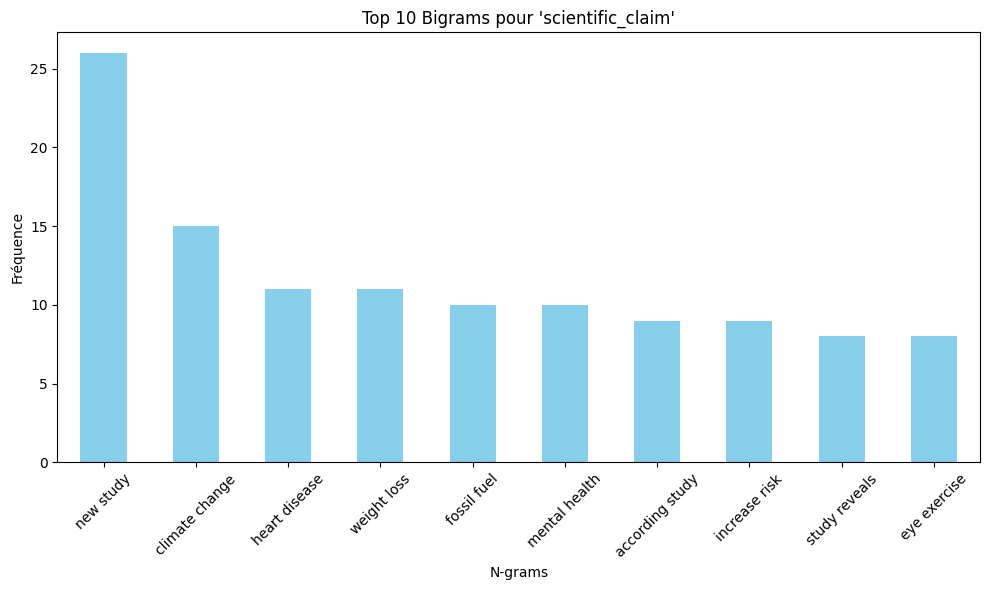

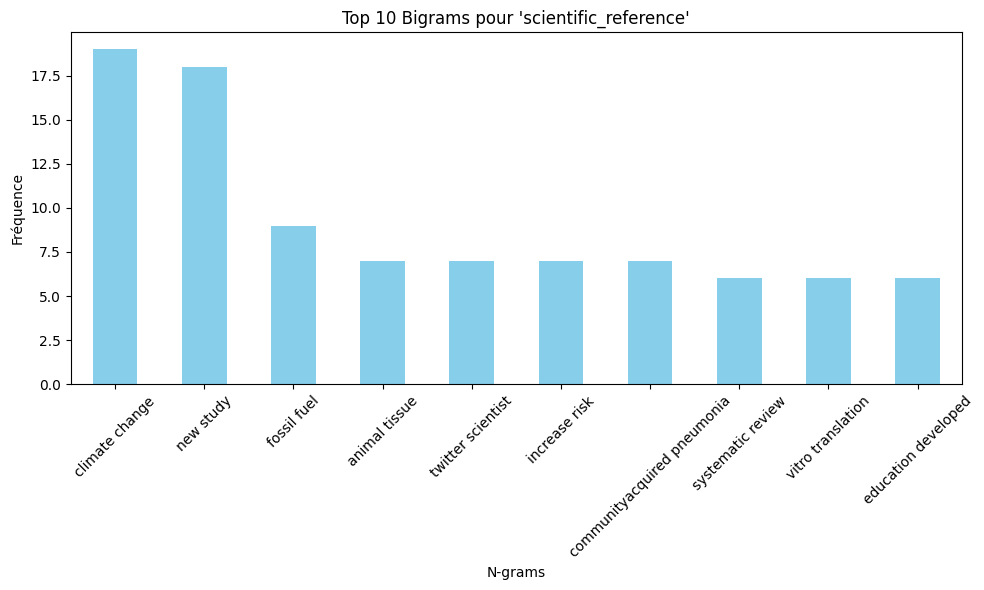

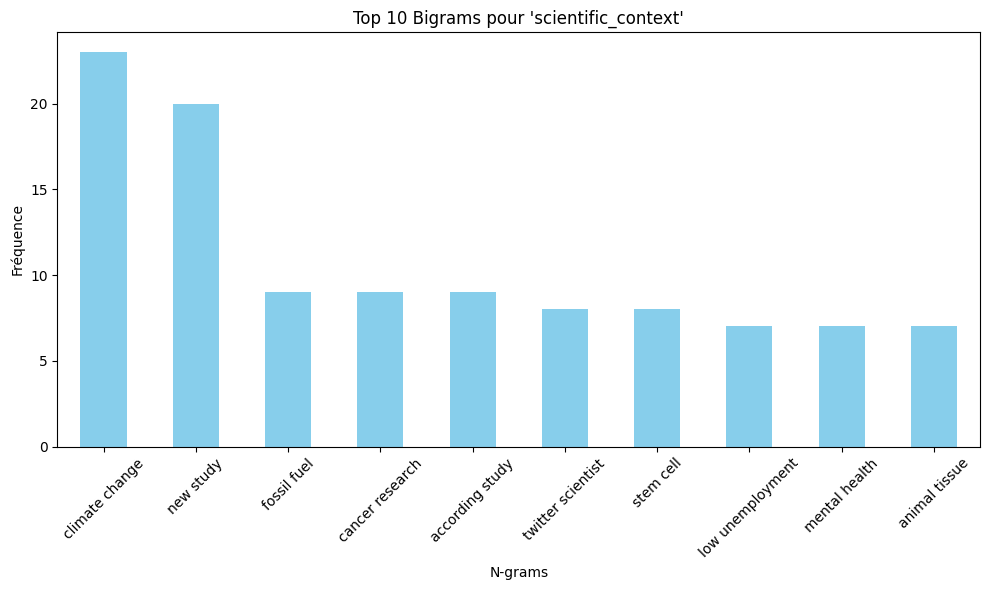

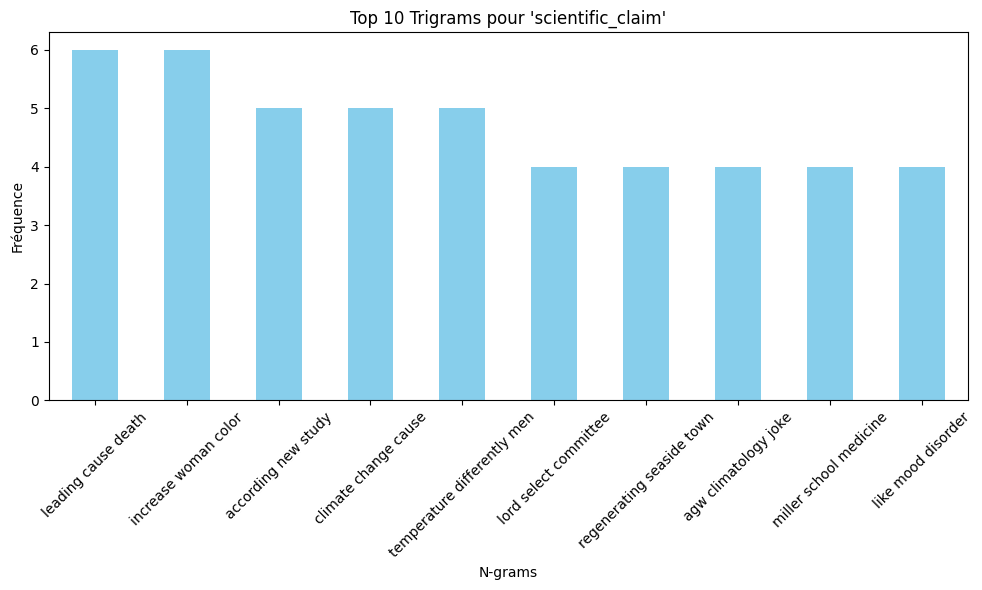

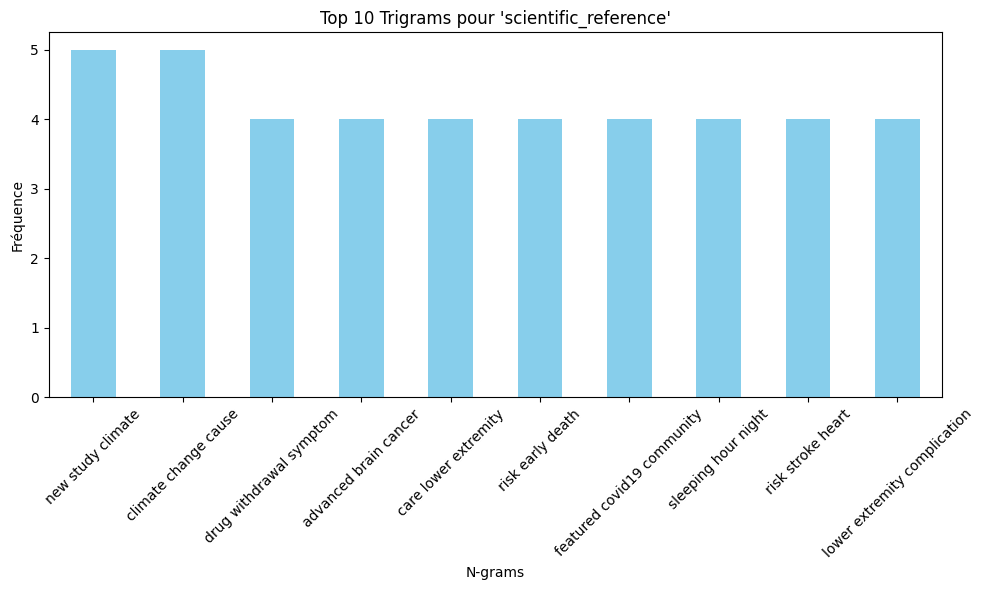

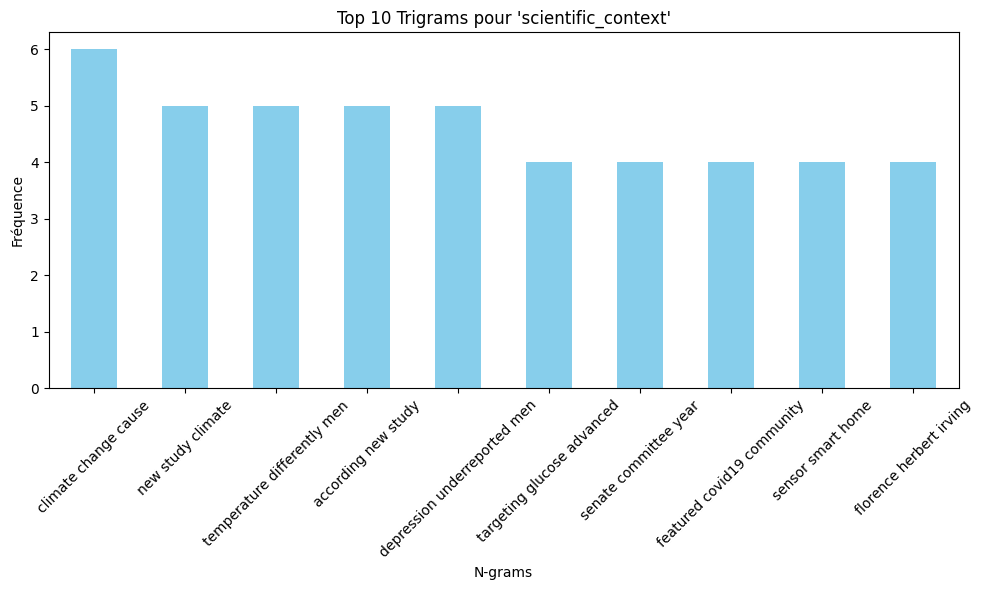

In [ ]:
def plot_ngram_frequencies(ngram_counts, title):
    plt.figure(figsize=(10, 6))
    ngram_counts.head(10).plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('N-grams')
    plt.ylabel('Fréquence')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_ngram_frequencies(claim_bigrams, "Top 10 Bigrams pour 'scientific_claim'")
plot_ngram_frequencies(reference_bigrams, "Top 10 Bigrams pour 'scientific_reference'")
plot_ngram_frequencies(context_bigrams, "Top 10 Bigrams pour 'scientific_context'")


plot_ngram_frequencies(claim_trigrams, "Top 10 Trigrams pour 'scientific_claim'")
plot_ngram_frequencies(reference_trigrams, "Top 10 Trigrams pour 'scientific_reference'")
plot_ngram_frequencies(context_trigrams, "Top 10 Trigrams pour 'scientific_context'")


#DIVERSITE LEXICALE

In [ ]:

def lexical_diversity(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words)


def lexical_diversity_by_class(df, column_name):
    filtered_df = df[df[column_name] == 1]
    filtered_df['lexical_diversity'] = filtered_df['text'].apply(lexical_diversity)
    return filtered_df['lexical_diversity'].mean()

claim_density = lexical_diversity_by_class(df_final, 'scientific_claim')
reference_density = lexical_diversity_by_class(df_final, 'scientific_reference')
context_density = lexical_diversity_by_class(df_final, 'scientific_context')


print(f"Densité lexicale pour 'scientific_claim' : {claim_density}")
print(f"Densité lexicale pour 'scientific_reference' : {reference_density}")
print(f"Densité lexicale pour 'scientific_context' : {context_density}")




#Recherche de thèmes

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_final['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)


n_top_words = 10
terms = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #1:
stop people support new science report help change life increase
Topic #2:
stop support report cause science people increase need dont life
Topic #3:
support stop science time study year new lead people treat
Topic #4:
stop support lead report great year research cancer people cause
Topic #5:
stop support cause report new day increase free need dont


#TSNE

#Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

doc1 = df['text'][0]
doc2 = df['text'][1]

X_new = vectorizer.transform([doc1, doc2])

cos_sim = cosine_similarity(X_new[0], X_new[1])
print(f"Similarité cosinus entre les deux documents : {cos_sim[0][0]}")


Similarité cosinus entre les deux documents : 0.3821766663508106


#PAR CLASSE

In [ ]:
def apply_lda_by_class(df, column_name, n_topics=5):
    filtered_df = df[df[column_name] == 1]

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(filtered_df['text'])

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    terms = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        topic_terms = [terms[i] for i in topic.argsort()[:-10 - 1:-1]]
        topics.append(f"Topic #{topic_idx + 1}: {' '.join(topic_terms)}")

    return topics

claim_topics = apply_lda_by_class(df_final, 'scientific_claim', n_topics=5)
reference_topics = apply_lda_by_class(df_final, 'scientific_reference', n_topics=5)
context_topics = apply_lda_by_class(df_final, 'scientific_context', n_topics=5)

print("Topics pour 'scientific_claim':")
for topic in claim_topics:
    print(topic)

print("\nTopics pour 'scientific_reference':")
for topic in reference_topics:
    print(topic)

print("\nTopics pour 'scientific_context':")
for topic in context_topics:
    print(topic)


Topics pour 'scientific_claim':
Topic #1: http https study new men women prevent world higher suggests
Topic #2: https people increase http changes pain exercise stop study brain
Topic #3: https http cancer change earth planet increase save bc certified
Topic #4: https http leads health new cause poverty day study suicide
Topic #5: https sleep http cause men stem increases diabetes feel health

Topics pour 'scientific_reference':
Topic #1: https http climate science change new big report eurekamag study
Topic #2: http https study eurekamag health finds brain decline discuss dcbms4mjb6
Topic #3: https new cancer brain research http fossil people article infection
Topic #4: https http n2qjtjq8tu women study analysis new heart speaking make
Topic #5: https health diabetes http study causes improve right psychological education

Topics pour 'scientific_context':
Topic #1: https http study new women cancer eurekamag stem scientists earth
Topic #2: https http infection study cause risk repor